In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
az.rcParams["stats.information_criterion"] = "waic"  # set information criterion to use in `compare`
az.rcParams["stats.ic_scale"] = "deviance"  # set information criterion scale
np.random.seed(0)

#### Code 8.1

In [3]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

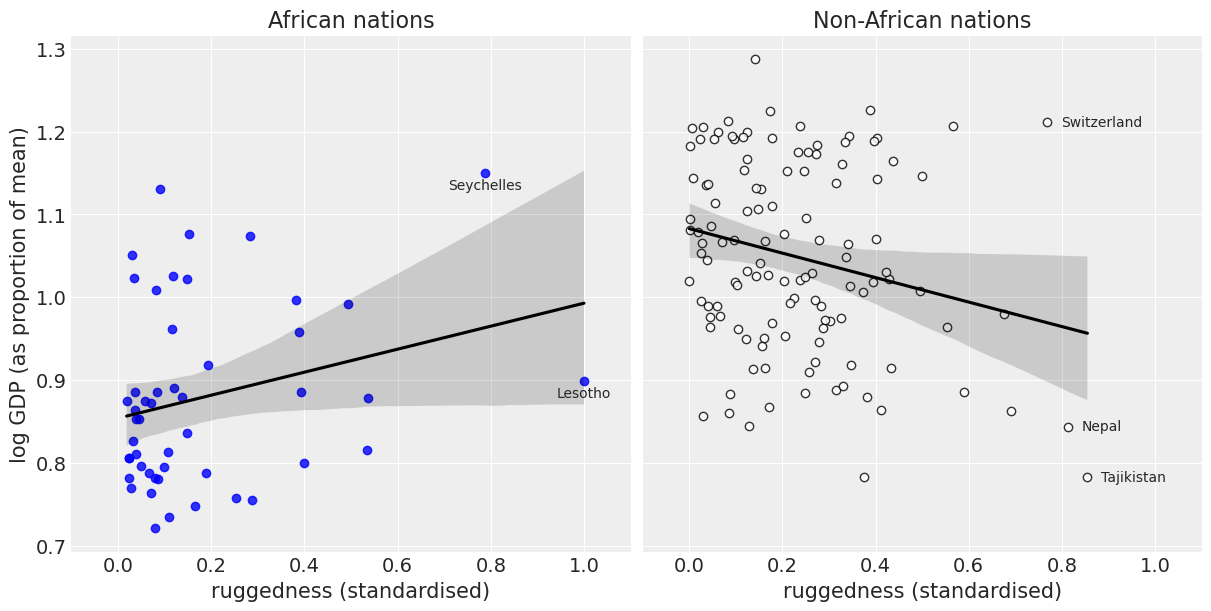

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.regplot(
    x=dd.loc[dd["cont_africa"] == 1]["rugged_std"],
    y=dd.loc[dd["cont_africa"] == 1]["log_gdp_std"],
    scatter_kws={"color": "b"},
    line_kws={"color": "k"},
    ax=axs[0],
)
sns.regplot(
    x=dd.loc[dd["cont_africa"] == 0]["rugged_std"],
    y=dd.loc[dd["cont_africa"] == 0]["log_gdp_std"],
    scatter_kws={"edgecolor": "k", "facecolor": "w"},
    line_kws={"color": "k"},
    ax=axs[1],
)

axs[0].set_ylabel("log GDP (as proportion of mean)")
axs[1].set_ylabel("")
axs[0].set_title("African nations")
axs[1].set_title("Non-African nations")

# label countries
for _, africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 1)].iterrows():
    axs[0].text(
        africa["rugged_std"],
        africa["log_gdp_std"] - 0.02,
        africa["country"],
        ha="center",
    )

for _, non_africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 0)].iterrows():
    axs[1].text(
        non_africa["rugged_std"] + 0.03,
        non_africa["log_gdp_std"],
        non_africa["country"],
        va="center",
    )

for ax in axs:
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("ruggedness (standardised)")

#### Code 8.2

In [5]:
with pm.Model() as m_8_1:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)

    mu = a + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, shape=dd.shape[0])

#### Code 8.3

In [6]:
with m_8_1:
    prior_8_1 = pm.sample_prior_predictive()

# Figure 8.3 is below

Sampling: [a, b, log_gdp_std, sigma]


#### Code 8.4

In [7]:
beta_prior = az.extract(prior_8_1.prior)["b"].to_numpy()
np.sum(np.abs(beta_prior > 0.6)) / len(beta_prior)

0.264

#### Code 8.5

In [8]:
with pm.Model() as m_8_1t:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)

    mu = a + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    idata_8_1t = pm.sample(idata_kwargs={"log_likelihood": True})

    prior_8_1t = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [a, b, log_gdp_std, sigma]


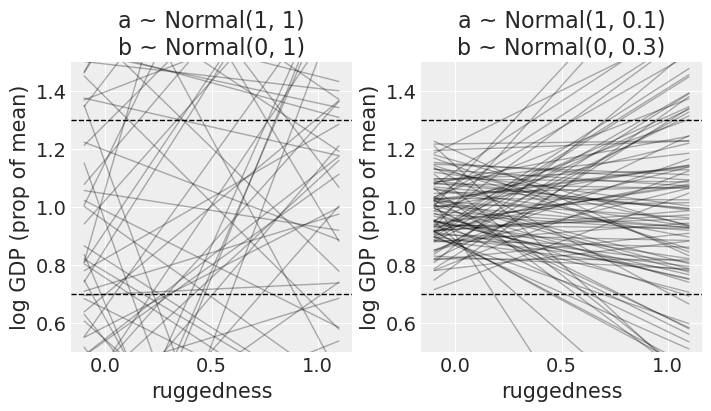

In [9]:
# Figure 8.3

_, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 4], constrained_layout=True)

n = 100
rugged_plot = np.linspace(-0.1, 1.1, n)

# Prior 1
prior = prior_8_1.prior.sel(draw=slice(None, None, int(len(prior_8_1.prior.draw) / n)))
reglines = prior["a"].T.to_numpy() + rugged_plot * prior["b"].T.to_numpy()
for regline in reglines:
    ax1.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax1.set_title("a ~ Normal(1, 1)\nb ~ Normal(0, 1)")

# Prior 2
prior_t = prior_8_1t.prior.sel(draw=slice(None, None, int(len(prior_8_1t.prior.draw) / n)))
reglines_t = prior_t["a"].T.to_numpy() + rugged_plot * prior_t["b"].T.to_numpy()

for regline in reglines_t:
    ax2.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax2.set_title("a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_ylabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)

#### Code 8.6

In [10]:
az.summary(idata_8_1t, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.10,0.09
sigma,0.14,0.01,0.13,0.15


#### Code 8.7

In [11]:
cid = pd.Categorical(dd["cont_africa"])

#### Code 8.8

In [12]:
with pm.Model() as m_8_2:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3)

    mu = a[np.array(cid)] + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    idata_8_2 = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


#### Code 8.9

In [13]:
az.compare({"m_8_1t": idata_8_1t, "m_8_2": idata_8_2})

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m_8_2,0,-252.350920,4.096586,0.000000,0.970287,14.780415,0.000000,True,deviance
m_8_1t,1,-188.746378,2.642777,63.604542,0.029713,12.964924,14.619768,False,deviance


#### Code 8.10

In [14]:
az.summary(idata_8_2, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.06
a[1],0.88,0.02,0.86,0.91
b,-0.05,0.05,-0.12,0.03
sigma,0.11,0.01,0.10,0.12


#### Code 8.11

In [15]:
m_8_2_posterior = az.extract(idata_8_2.posterior)
diff_a0_a1 = m_8_2_posterior["a"][1, :] - m_8_2_posterior["a"][0, :]
az.hdi(diff_a0_a1.to_numpy())

array([-0.1993624 , -0.13793349])

#### Code 8.12

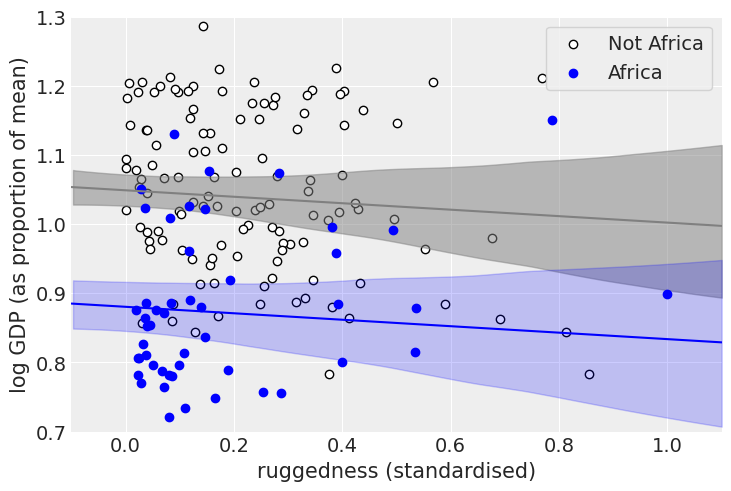

In [16]:
fig, ax = plt.subplots()

# extract posterior samples of parameters
a0 = m_8_2_posterior["a"][0, :].to_numpy()
a1 = m_8_2_posterior["a"][1, :].to_numpy()
b = m_8_2_posterior["b"].to_numpy()

rugged_plot = np.linspace(-0.1, 1.1)

ax.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
pred0 = a0 + rugged_plot.reshape(-1, 1) * b
ax.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax)

ax.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
pred1 = a1 + rugged_plot.reshape(-1, 1) * b
ax.plot(rugged_plot, pred1.mean(1), color="b")
az.plot_hdi(rugged_plot, pred1.T, color="b", hdi_prob=0.97, ax=ax, fill_kwargs={"alpha": 0.2})

ax.legend(frameon=True)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0.7, 1.3)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)");

#### Code 8.13

In [20]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    idata_8_3 = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


#### Code 8.14

In [21]:
az.summary(idata_8_3, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.04,1.07
a[1],0.89,0.02,0.86,0.91
b[0],-0.14,0.06,-0.23,-0.05
b[1],0.13,0.08,0.01,0.25
sigma,0.11,0.01,0.10,0.12


#### Code 8.15

In [22]:
az.compare({"m_8_1t": idata_8_1t, "m_8_2": idata_8_2, "m_8_3": idata_8_3}, ic="loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_8_3,0,-259.037278,5.067643,0.000000,8.556405e-01,14.629119,0.000000,False,deviance
m_8_2,1,-252.307824,4.118134,6.729454,1.443595e-01,14.792647,6.493970,False,deviance
m_8_1t,2,-188.734825,2.648554,70.302453,1.110223e-16,12.965634,14.911593,False,deviance


#### Code 8.16

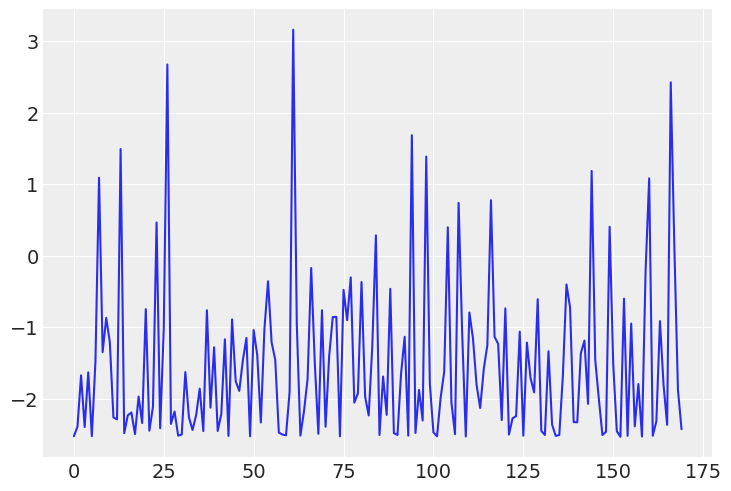

In [23]:
m_8_3_loo = az.loo(idata_8_3, pointwise=True)

plt.plot(m_8_3_loo.loo_i)

#### Code 8.17

In [24]:
m_8_3_posterior = az.extract(idata_8_3.posterior)

Text(0, 0.5, 'log GDP (as proportion of mean)')

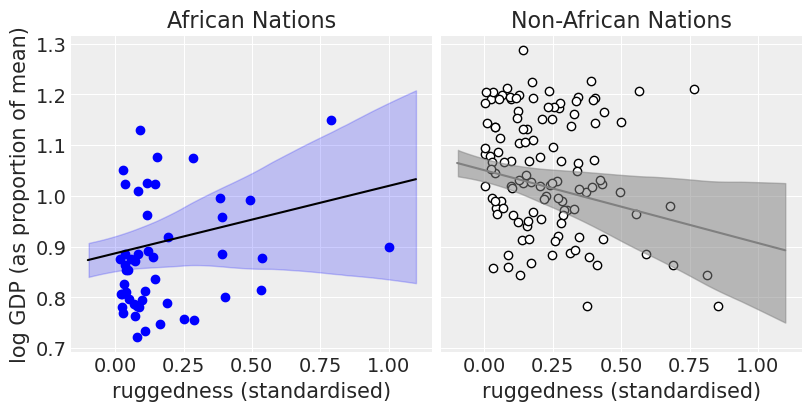

In [25]:
_, axs = plt.subplots(
    1,
    2,
    figsize=[8, 4],
    sharey=True,
    constrained_layout=True,
)

ax1, ax0 = axs

# extract posterior samples of parameters
a0 = m_8_3_posterior["a"][0, :].to_numpy()
a1 = m_8_3_posterior["a"][1, :].to_numpy()
b0 = m_8_3_posterior["b"][0, :].to_numpy()
b1 = m_8_3_posterior["b"][1, :].to_numpy()

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred0 = a0 + rugged_plot.reshape(-1, 1) * b0
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax0)
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred1 = a1 + rugged_plot.reshape(-1, 1) * b1
ax1.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hdi(
    rugged_plot,
    pred1.T,
    color="blue",
    hdi_prob=0.97,
    ax=ax1,
    fill_kwargs={"alpha": 0.2},
)
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax0.set_ylabel("")
ax1.set_ylabel("log GDP (as proportion of mean)")

#### Code 8.18

(0.0, 1.0)

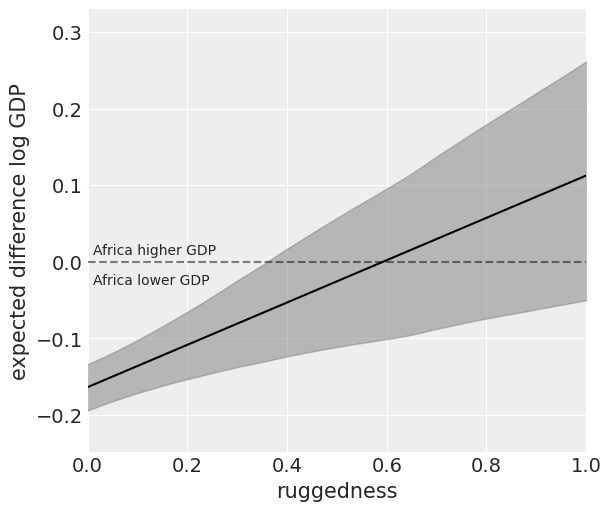

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))

rugged_plot = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

ax.plot(rugged_plot, delta.mean(1), c="k")
az.plot_hdi(rugged_plot, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference log GDP")
ax.set_xlim(0, 1)

These numbers are quite different from the book - not sure why.

#### Code 8.19

In [27]:
d = pd.read_csv("Data/tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


$$B_i \sim Normal(\mu_i,\sigma)$$

$$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S})$$

#### Code 8.20

In [28]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

#### Code 8.21

In [29]:
a = stats.norm.rvs(0.5, 1, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.6092

#### Code 8.22

In [30]:
a = stats.norm.rvs(0.5, 0.25, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.0447

#### Code 8.23

In [31]:
with pm.Model() as m_8_4:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)

    mu = a + bw * d["water_cent"].values + bs * d["shade_cent"].values
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    idata_8_4 = pm.sample()
    post_8_4 = az.extract(idata_8_4["posterior"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


$$B_i \sim Normal(\mu_i,\sigma)$$

$$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S}) +\beta_{WS}W_iS_i $$

#### Code 8.24

In [32]:
with pm.Model() as m_8_5:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)

    mu = (
        a
        + bw * d["water_cent"].values
        + bs * d["shade_cent"].values
        + bws * d["water_cent"].values * d["shade_cent"].values
    )
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    idata_8_5 = pm.sample()
    post_8_5 = az.extract(idata_8_5.posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, bws, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


#### Code 8.25

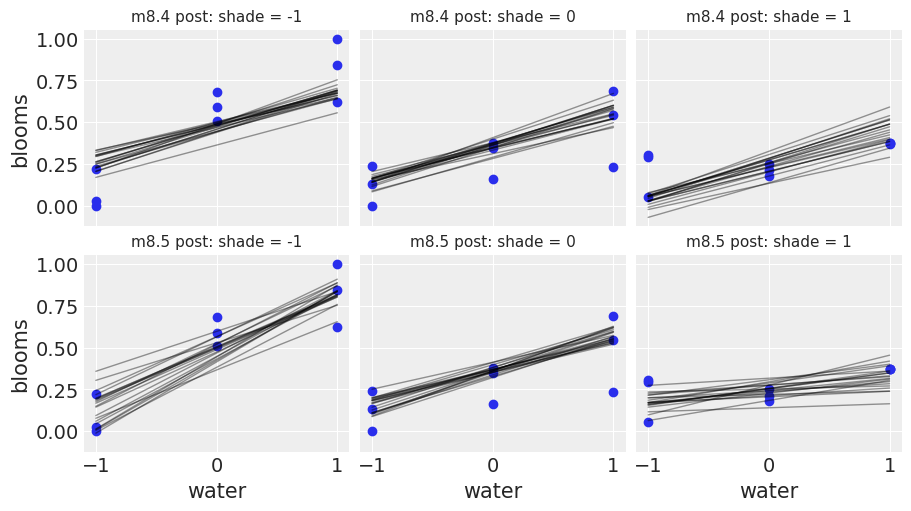

In [33]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(d.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        post_8_4["a"][:n_lines].to_numpy()
        + post_8_4["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + post_8_4["bs"][:n_lines].to_numpy() * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        post_8_5["a"][:n_lines].to_numpy()
        + post_8_5["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + post_8_5["bs"][:n_lines].to_numpy() * shade
        + post_8_5["bws"][:n_lines].to_numpy() * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

for ax in axs.flat:
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("blooms")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("water");

#### Code 8.26

In [34]:
with m_8_4:
    prior_8_4 = pm.sample_prior_predictive(var_names=["a", "bw", "bs"])
    prior_8_4 = az.extract(prior_8_4["prior"])

with m_8_5:
    prior_8_5 = pm.sample_prior_predictive(var_names=["a", "bw", "bs", "bws"])
    prior_8_5 = az.extract(prior_8_5["prior"])

Sampling: [a, bs, bw]
Sampling: [a, bs, bw, bws]


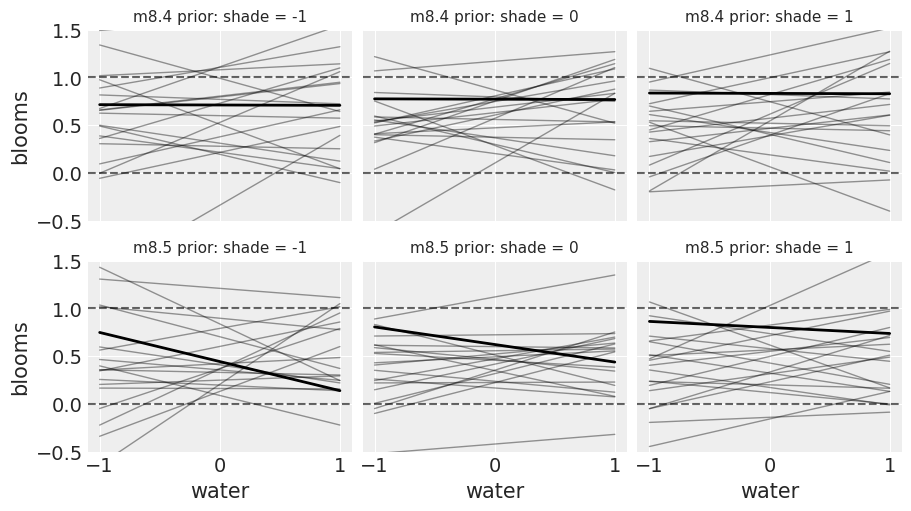

In [35]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        prior_8_4["a"][:n_lines].to_numpy()
        + prior_8_4["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + prior_8_4["bs"][:n_lines].to_numpy() * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        prior_8_5["a"][:n_lines].to_numpy()
        + prior_8_5["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + prior_8_5["bs"][:n_lines].to_numpy() * shade
        + prior_8_5["bws"][:n_lines].to_numpy() * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

for ax in axs.flat:
    ax.set_ylim(-0.5, 1.5)
    ax.axhline(1, ls="dashed", color=(0, 0, 0, 0.6))
    ax.axhline(0, ls="dashed", color=(0, 0, 0, 0.6))
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("blooms")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("water");

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 07 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

arviz     : 0.17.0
pandas    : 2.1.4
seaborn   : 0.12.2
scipy     : 1.11.4
pymc      : 5.10.3
matplotlib: 3.8.2
numpy     : 1.26.3

Watermark: 2.4.3

